# Labor 05: Többosztályos klasszifikáció - Egy vs Többi (One vs All)

### Kézzel írott számjegyek

Ebben a feladatban logisztikus regressziót fogunk alkalmazni, hogy elkülönítsünk kézzel írt számjegyeket (0 és 9 között). Ez a feladat manapság elterjedt a póstai irányítószám leolvasásától kezdve a banki számlákon beírt számok felismeréséig és tovább.

### 1: importáljuk be a megfelelő csomagokat

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat

### 2: Adatok beolvasása és vizualizálása

A Lab5data.mat fájl tartalmazza az adatainkat. A fájl 5000 darab 20x20 pixeles mintaképet tartalmaz. A mátrixban egy minta egy sornak felel meg, melyhez a képeket kiterítettük. A kiterítésre példa alább.

<img src="files/Pics/L05_Flatten.png" width=450>

Ennek megfelelően az adatokat beolvasva egy 5000x400-as bemeneti mátrixot fogunk kapni és egy 5000x1-es mátrixot, amik a címkéket tartalmazzák.

A megjelenítéshez pedig értelem szerűen ennek megfelelően kell a képeket vissza alakítanunk. A későbbiek során az algoritmusunknak minden pixel egy bemeneti változónak fog számítani, és minden pixel értéke egy 0-2 közé normalizált szürke árnyalatos érték. 

Shape of the dataset in order X and Y:
 (5000, 400) 
 (5000, 1) 

Now showing some random data from the dataset ...


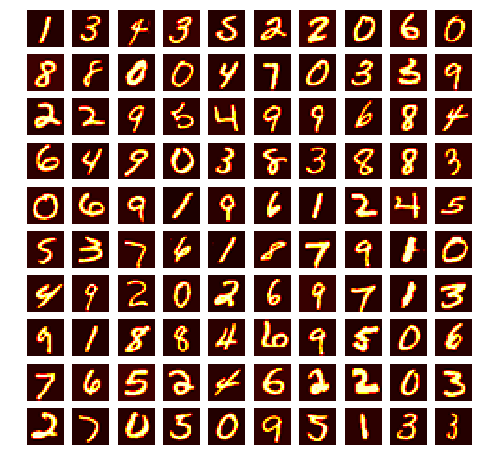

In [2]:
mat = loadmat("Lab5data.mat")                                       # .mat file beolvasása
X = mat["X"]                                                        # X rendezése
Y = mat["y"]                                                        # Y rebbdezése
m = X.shape[0]                                                      # adatok

print('''Shape of the dataset in order X and Y:
''',X.shape,'\n',Y.shape,'\n')

print("Now showing some random data from the dataset ...")          # kirajzoltatunk néhány random elemet
fig, axis = plt.subplots(10,10,figsize = (8,8))                     # mivel egy plotra akarunk több ábrát -> subplots
for i in range(10):                                                 # 10 x 10 kis ábrát akarunk
    for j in range(10):
        axis[i,j].imshow(X[np.random.randint(0,m+1),:].reshape(20,20,order="F"),cmap="hot")   # random beolvasás
        axis[i,j].axis("off")
plt.show()

### 3: Költségfüggvény és Gradient Descent

Emlékeztető:

In [3]:
def sigmoid(z):
    return 1/(1+np.exp(-z))                                                 # szigmoid függvény definíció

def lrCostFunction(w,X,Y,Lambda):                                           # logaritmusos költségfüggvény definíció
####################################################################
    m = len(Y)
    
    h = sigmoid(X@w) 
    w_reg = np.append(0, w[1:]).reshape(-1,1)
    
    p = Lambda/(2*m) * np.sum(w[1:]**2)
    C = (1/m) * np.sum((-Y * np.log(h)) - ((1-Y) * np.log(1-h))) + p 
    
    grad = 1/m * (X.transpose() @ (h-Y)) + (Lambda/m)*w_reg
####################################################################
    return C, grad

In [4]:
w_t = np.array([-2,-1,1,2]).reshape(4,1)                                 # teszt eset
X_t = np.array([np.linspace(0.1,1.5,15)]).reshape(3,5).T                  
X_t = np.hstack((np.ones((5,1)),X_t))                                    
Y_t = np.array([1,0,1,0,1]).reshape(5,1)  
Lambda = 3

C,grad = lrCostFunction(w_t, X_t, Y_t, Lambda)                           # költségfüggvény Lambda = 3
print('\nTest weight: [-2 -1 1 2]\n''''
Testing lrCostFunction() with regularization ... 
Cost function value: %.6f''' % C, ' (Expected: 2.534819)')
print('''\nExpected gradients:
 [[0.146561]
 [-0.548558]
 [0.724722]
 [1.398003]]
Computed gradients:\n''',grad)


Test weight: [-2 -1 1 2]

Testing lrCostFunction() with regularization ... 
Cost function value: 2.534819  (Expected: 2.534819)

Expected gradients:
 [[0.146561]
 [-0.548558]
 [0.724722]
 [1.398003]]
Computed gradients:
 [[ 0.14656137]
 [-0.54855841]
 [ 0.72472227]
 [ 1.39800296]]


In [ ]:
def gradientDescent(X,Y,w,learning_rate,num_iters,Lambda):                          # grádiens módszer definíciója
    C_history = []

    for i in range(num_iters):
        C, grad =lrCostFunction(w,X,Y,Lambda)
        w = w - (learning_rate * grad)
        C_history.append(C)

    return w, np.array(C_history)

### 4: One vs All

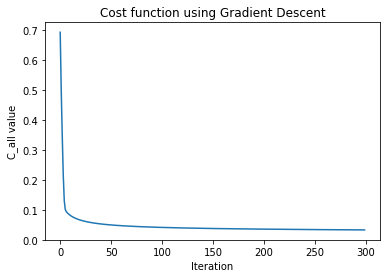

In [5]:
def oneVsAll(X, Y, num_labels, Lambda):                                     # One vs All definíciója
    m, n = X.shape[0],X.shape[1]                                            # 
    w_init = np.zeros((n + 1, 1))                                           # init súly oszlopvektor, n+1 x 1
    w_all = []  
    C_all = []

    X = np.hstack((np.ones((m, 1)), X))

    for i in range(1,num_labels + 1):
        w, C_history = gradientDescent(X, np.where(Y == i, 1, 0), w_init, 1, 300, Lambda)
        w_all.extend(w)
        C_all.extend(C_history)

    return np.array(w_all).reshape(num_labels, n + 1), C_all



w_all, C_all = oneVsAll(X,Y,10,0.1)
plt.plot(C_all[0:300])
plt.title("Cost function using Gradient Descent")
plt.xlabel("Iteration")
plt.ylabel("C_all value")
plt.show()

### 5: Predikció és pontosság

In [6]:
def predictionOneVsAll(w_all,X):
    m = X.shape[0]
    X = np.hstack((np.ones((m,1)),X))

    predictions = X @ w_all.T
    return np.argmax(predictions,axis=1)+1                      # alapból eggyel kevesebbet ad vissza 

pred = predictionOneVsAll(w_all, X)
acc = sum(pred[:,np.newaxis]==Y)[0]/5000*100
print("Training Set Accuracy:", acc,"%")

Training Set Accuracy: 91.46 %
